### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.manifold import TSNE

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [8]:
fine_tune_data_resnet = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_resnet.shape

(16000, 5, 2048)

In [9]:
N_COMPS_1 = 1300 # 1600
N_COMPS_2 = 300 # 400
N_COMPS_3 = 900 # 1000
random_state = 43

In [10]:

pcas_resnet = [PCA(N_COMPS_1, random_state=random_state) for _ in range(5)]

In [11]:
for i in range(5):
    pcas_resnet[i].fit(fine_tune_data_resnet[:,i,:])

In [12]:
fine_tune_data_train_red_resnet = np.zeros((fine_tune_data_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_train_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_resnet[:,i,:])
fine_tune_data_resnet = fine_tune_data_train_red_resnet
del fine_tune_data_train_red_resnet

In [13]:
fine_tune_data_resnet.shape

(16000, 5, 1300)

In [14]:
fine_tune_data_vgg = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_vgg.shape

(16000, 5, 512)

In [15]:

pcas_vgg = [PCA(N_COMPS_2, random_state=random_state) for _ in range(5)]

In [16]:
for i in range(5):
    pcas_vgg[i].fit(fine_tune_data_vgg[:,i,:])

In [17]:
fine_tune_data_train_red_vgg = np.zeros((fine_tune_data_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_train_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_vgg[:,i,:])
fine_tune_data_vgg = fine_tune_data_train_red_vgg
del fine_tune_data_train_red_vgg
fine_tune_data_vgg.shape

(16000, 5, 300)

In [18]:
fine_tune_data_inception_resnet = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_inception_resnet.shape

(16000, 5, 1536)

In [19]:

pcas_inception_resnet = [PCA(N_COMPS_3, random_state=random_state) for _ in range(5)]

In [20]:
for i in range(5):
    pcas_inception_resnet[i].fit(fine_tune_data_inception_resnet[:,i,:])

In [21]:
fine_tune_data_train_red_inception_resnet = np.zeros((fine_tune_data_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_train_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_inception_resnet[:,i,:])
fine_tune_data_inception_resnet = fine_tune_data_train_red_inception_resnet
del fine_tune_data_train_red_inception_resnet
fine_tune_data_inception_resnet.shape

(16000, 5, 900)

In [22]:
fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg, fine_tune_data_inception_resnet], axis=-1)
fine_tune_data.shape

(16000, 5, 2500)

In [23]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [24]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2500)

In [25]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [26]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2500)

In [27]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

Loading the CNN based trained model and generating data for XGBoost

In [28]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS_1 + N_COMPS_2 + N_COMPS_3))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-VGG-Inception-ResNet-FineTune')
    return model1

In [29]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max
Model: "RestNet-VGG-Inception-ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2500)]         0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 batch_normalization (BatchN  (None, 12500)            50000     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 12500)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6400512   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048  

2022-10-10 04:05:56.415611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-10 04:05:56.415702: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [31]:
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-4P/auto-ResNet-VGG-Inception-ResNet-FT-model-weight')

In [32]:
model1.get_layer(index=len(model1.layers)-3).output

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'batch_normalization_1')>

In [33]:
model2 = tf.keras.Model(model1.input, model1.get_layer(index=len(model1.layers)-3).output)

In [34]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2500)]         0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 batch_normalization (BatchN  (None, 12500)            50000     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 12500)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6400512   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                             

In [35]:
data_train = model2.predict(fine_tune_data_train)
data_train.shape

 66/475 [===>..........................] - ETA: 0s

2022-10-10 04:05:57.490467: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-10 04:05:57.530551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 2ms/step


(15200, 512)

In [36]:
data_test = model2.predict(fine_tune_data_test)
data_test.shape

25/25 [==============================] - 0s 2ms/step


(800, 512)

In [47]:
data_viz = model2.predict(fine_tune_data)
data_viz.shape

500/500 [==============================] - 1s 1ms/step


(16000, 512)

## T-SNE

In [48]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd = tsne.fit_transform(data_viz)

In [49]:
labs = labels['label'].to_numpy()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'cornflowerblue', 'burlywood', 'magenta', 'indigo']

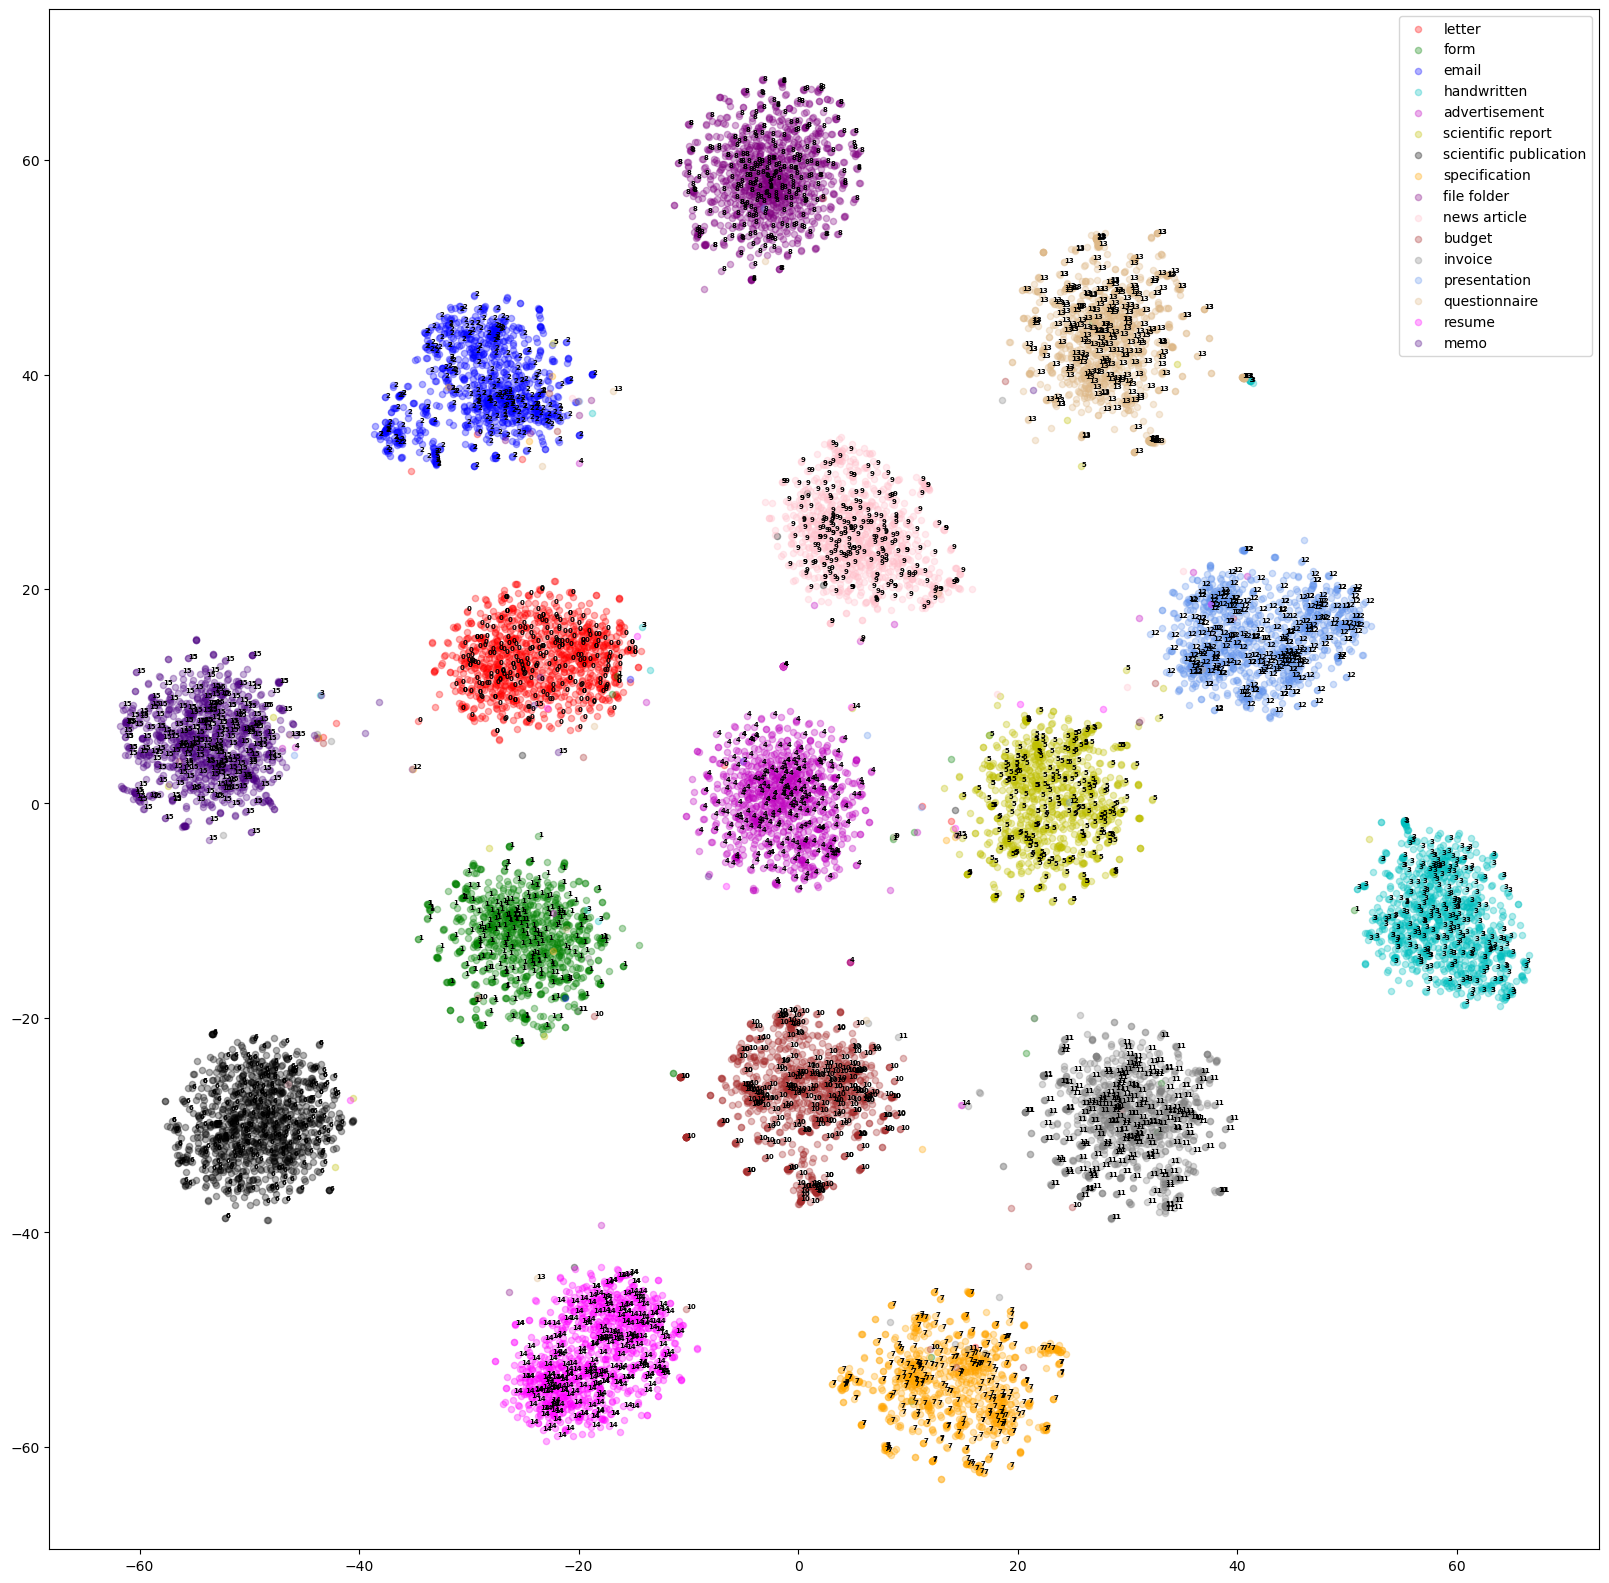

In [50]:
plt.figure(figsize=(20, 20))
for lab, col in zip(class_labels, colors):
    plt.scatter(tsne_embd[labs==lab,0], tsne_embd[labs==lab,1], s=20, c=col, alpha=0.3, label=class_names[lab])
    
    rand = np.random.choice(np.sum(labs==lab), np.sum(labs==lab)//4)
    for pt in rand:
        plt.annotate(lab, (tsne_embd[labs==lab,0][pt], tsne_embd[labs==lab,1][pt]), size=5, weight='bold', color='k')   
plt.legend()
plt.show()